## Hyperparameters optimization for Random Forest in the case of binary class (Sell, Buy)

In this case, Random Forest, adding our data doesn't provide any value. Of course, the in sample strategy is winning, by definition. We wan to predict the Buy signal and in sample, we succeed around 75% of the times. Since Buy means we got a profit, the cumulative profit is skayrocketing. Unfortunately, out of sample the performance is poor.

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold




In [2]:
# Get underlying prices
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [3]:
target = pd.read_csv("../data/processed/target_df.csv", index_col = 0)["target"]

In [4]:
# Get the working dataframe
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [5]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [6]:
interest_rate = wk_df["r"].values

### EDA for exp_price file

[Open report](exp_price_report.html)

In [7]:
def display_report(y_test:np.ndarray, predictions:np.ndarray)->None:
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return

In [8]:
def plot_feature_imp(coefficients:np.ndarray[float], columns:list[str])->None:

    feature_importance = pd.DataFrame({'Feature': columns, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
    plt.show()
    return

In [9]:
def get_params()->dict:
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 25)]
    # Number of features to consider at every split
    max_features = [None, 'sqrt', "log2"]
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Criterion
    criterion = ["gini", "entropy", "log_loss"]
    # Create the random grid
    random_grid = {'rf__n_estimators': n_estimators,
                'rf__max_features': max_features,
                'rf__max_depth': max_depth,
                'rf__min_samples_split': min_samples_split,
                'rf__min_samples_leaf': min_samples_leaf,
                'rf__bootstrap': bootstrap, 
                'rf__criterion':criterion,
                'rf__random_state':[1968]
                }
    
    return random_grid

## Baseline Random Forest Classifier without new data + r

In [10]:
orig_df = ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff_date"]].copy()

In [11]:
orig_df["r"] = interest_rate

In [12]:
X_train, X_test, y_train, y_test = train_test_split(orig_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [13]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier())])

In [14]:
n_iter = 200
verbose_level = 1
n_jobs = 4
cv = StratifiedKFold(4)
random_grid = get_params()

In [15]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, 
                               param_distributions = random_grid, 
                               n_iter = n_iter, 
                               cv = cv, 
                               scoring="recall",
                               verbose=verbose_level, 
                               random_state=1968, 
                               n_jobs = n_jobs)

In [16]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'rf__max_depth': [2, 4, 6, 8, 10, 12,
                                                          14, 16, 18, 20,
                                                          None],
                                        'rf__max_features': [None, 'sqrt',
                                                             'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 17, 25, 33, 41,
                                                             49, 57, 65, 73, 81,
                                                             89, 97, 105, 112,
                                                             120, 128, 136, 144,
                                                             152, 160, 168, 176,
                                                             184, 192, 200],
                                        'rf__random_state': [1968]},
                   random_state=1968, scoring='recall', verbose=1)

In [17]:
rf_random.best_params_

{'rf__random_state': 1968,
 'rf__n_estimators': 97,
 'rf__min_samples_split': 2,
 'rf__min_samples_leaf': 2,
 'rf__max_features': None,
 'rf__max_depth': None,
 'rf__criterion': 'entropy',
 'rf__bootstrap': True}

In [18]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__random_state,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__criterion,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
67,0.614584,0.016592,0.011478,0.000555,1968,97,2,2,None,None,entropy,True,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.758333,0.705882,0.773109,0.773109,0.752609,0.027644,1
153,0.801863,0.019048,0.014375,0.001147,1968,112,5,1,None,None,entropy,True,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.766667,0.680672,0.781513,0.764706,0.748389,0.039633,2
163,0.359180,0.009054,0.007528,0.000827,1968,57,10,4,None,14,entropy,True,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.766667,0.663866,0.764706,0.798319,0.748389,0.050590,2
100,0.110699,0.002826,0.005013,0.000103,1968,33,5,4,sqrt,20,log_loss,False,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.766667,0.672269,0.756303,0.781513,0.744188,0.042478,4
188,0.454935,0.006201,0.008810,0.000989,1968,73,10,1,None,12,entropy,True,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.766667,0.697479,0.739496,0.773109,0.744188,0.029772,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0.109729,0.003625,0.009565,0.000619,1968,49,5,1,sqrt,2,entropy,True,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.616667,0.386555,0.252101,0.252101,0.376856,0.148939,196
8,0.053752,0.000562,0.003703,0.000028,1968,25,10,4,None,2,log_loss,True,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.483333,0.277311,0.361345,0.369748,0.372934,0.073274,197
176,0.155326,0.003595,0.008698,0.000597,1968,73,10,1,log2,2,log_loss,True,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.566667,0.445378,0.268908,0.201681,0.370658,0.143970,198
13,0.671463,0.014876,0.019448,0.002936,1968,136,2,1,None,4,entropy,False,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.358333,0.336134,0.344538,0.436975,0.368995,0.040040,199


In [19]:
best_model = rf_random.best_estimator_

In [20]:
best_model.score(X_test, y_test)

0.749003984063745

In [21]:
predictions = best_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.72      0.79      0.75       123
           1       0.78      0.71      0.74       128

    accuracy                           0.75       251
   macro avg       0.75      0.75      0.75       251
weighted avg       0.75      0.75      0.75       251



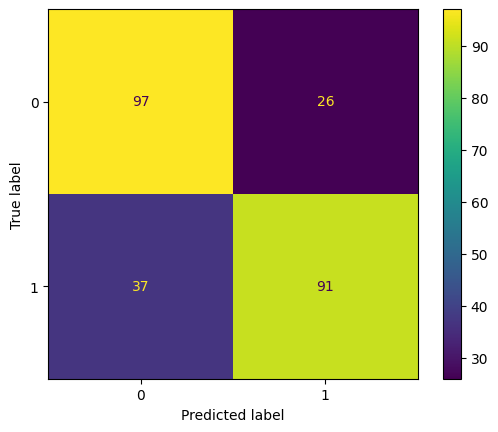

In [22]:
display_report(y_test, predictions)

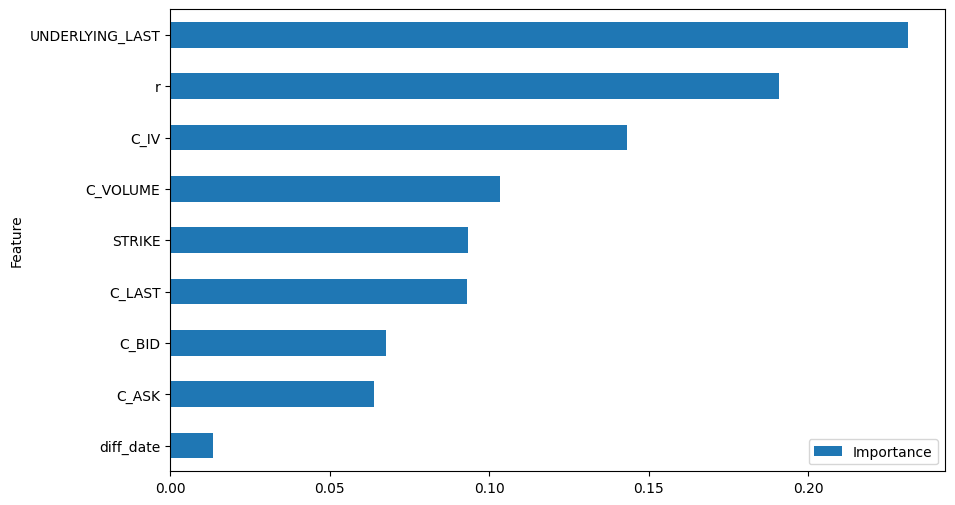

In [23]:
coefficients = best_model.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)


### Test model

In [24]:
X_train, X_test, y_train, y_test = train_test_split(orig_df.values, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=False)

In [25]:
rf_params = {k[4:]:v for k,v in rf_random.best_params_.items()} | {
 'n_jobs' : 4, 
 'verbose':1}

In [26]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier(**rf_params))])

In [27]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s


[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    0.4s finished


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(criterion='entropy', max_features=None,
                                        min_samples_leaf=2, n_estimators=97,
                                        n_jobs=4, random_state=1968,
                                        verbose=1))])

In [28]:
predictions = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    0.1s finished


In [29]:
pipe.score(X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    0.0s finished


0.6135458167330677

In [30]:
insample_preds = pipe.predict(X_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  97 out of  97 | elapsed:    0.0s finished


### Buy only strategy 

### in-sample

In [31]:
strategy = []
date_idx = []
prev_price = 0.0
for i in range(len(insample_preds)):
    row = orig_df.iloc[i,:].to_dict()
    quote_date = orig_df.index[i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    # Get price at expiration
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if insample_preds[i]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:
        if final_price > strike:
            profit = call_price
        else:
            profit = final_price-strike+call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.0,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [32]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_date,final_price,profit,bare
Date,,,,,,,
2018-01-02,1,269.0,1.56,2018-01-24,283.179993,12.619993,12.619993
2018-01-03,1,270.0,2.15,2018-01-24,283.179993,11.029993,11.029993
2018-01-04,1,272.0,1.67,2018-01-24,283.179993,9.509993,9.509993
2018-01-05,1,273.0,2.21,2018-01-26,286.579987,11.369987,11.369987
2018-01-08,1,274.0,2.08,2018-01-31,281.899994,5.819994,5.819994
...,...,...,...,...,...,...,...
2021-12-27,0,477.0,5.76,2022-01-18,456.489990,0.000000,-5.760000
2021-12-28,0,477.0,5.29,2022-01-18,456.489990,0.000000,-5.290000
2021-12-29,0,478.0,5.43,2022-01-19,451.750000,0.000000,-5.430000


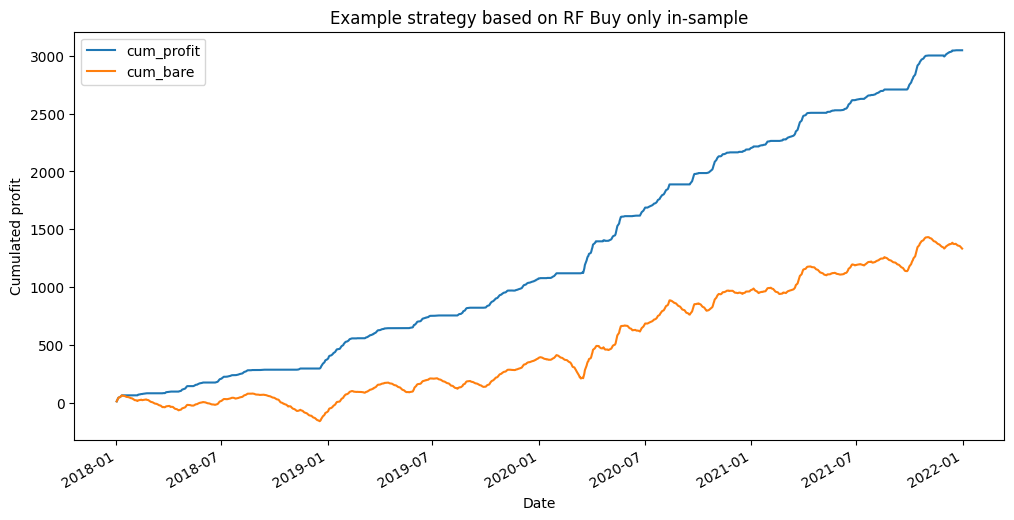

In [33]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on RF Buy only in-sample")
plt.legend()
plt.show()

### out-of-sample

In [34]:
strategy = []
date_idx = []
for x,i in enumerate(range(len(predictions),0,-1)):
    row = orig_df.iloc[-i,:].to_dict()
    quote_date = orig_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    final_price = spy.loc[exp_date,"Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:    
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [35]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_date,final_price,profit,bare
Date,,,,,,,
2022-01-03,0,478.0,4.81,2022-01-24,439.839996,0.0,-4.810000
2022-01-04,0,478.0,4.80,2022-01-24,439.839996,0.0,-4.800000
2022-01-05,0,468.0,8.14,2022-01-26,433.380005,0.0,-8.140000
2022-01-06,0,468.0,7.00,2022-01-26,433.380005,0.0,-7.000000
2022-01-07,0,466.0,7.56,2022-01-28,441.950012,0.0,-7.560000
...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,2023-01-13,398.500000,0.0,7.500000
2022-12-26,0,383.0,7.96,2023-01-13,398.500000,0.0,7.540000
2022-12-28,0,377.0,8.75,2023-01-20,395.880005,0.0,10.130005


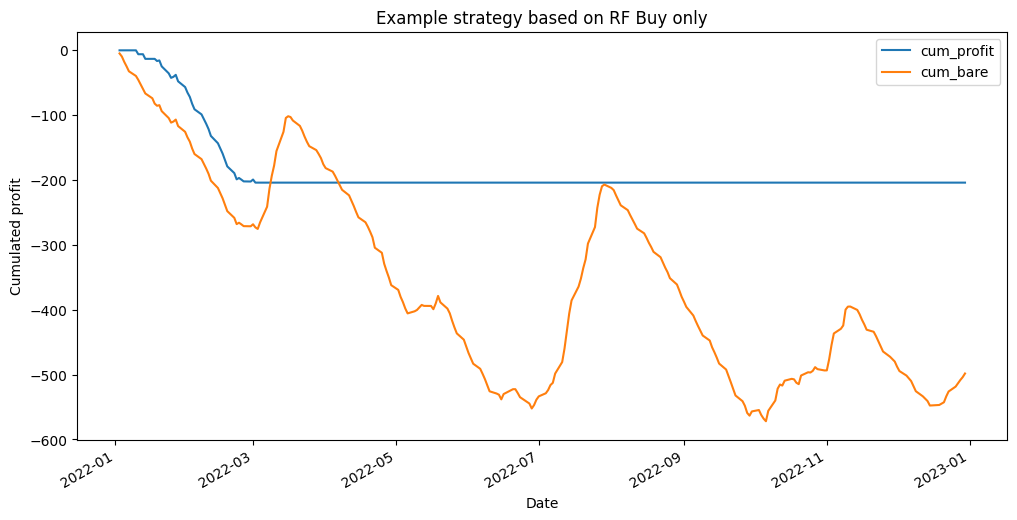

In [36]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on RF Buy only")
plt.legend()
plt.show()

## Random Forest with data from MC simulation and some addtional features

In [37]:
new_df = pd.concat((ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff"]],wk_df.drop(["last_quote", "strike"], axis=1) ), axis=1)

In [38]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"]-new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"]-new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"],2)
new_df["exp_profit"] = new_df["exp_price"]-(new_df["STRIKE"]+new_df["C_LAST"])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(new_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [40]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier())])

In [41]:
n_iter = 200
verbose_level = 1
n_jobs = 4
cv = StratifiedKFold(4)
random_grid = get_params()

In [42]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, 
                               param_distributions = random_grid, 
                               n_iter = n_iter, 
                               cv = cv,
                               scoring="recall",
                               verbose=verbose_level, 
                               random_state=1968, 
                               n_jobs = n_jobs)

In [43]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'rf__max_depth': [2, 4, 6, 8, 10, 12,
                                                          14, 16, 18, 20,
                                                          None],
                                        'rf__max_features': [None, 'sqrt',
                                                             'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 17, 25, 33, 41,
                                                             49, 57, 65, 73, 81,
                                                             89, 97, 105, 112,
                                                             120, 128, 136, 144,
                                                             152, 160, 168, 176,
                                                             184, 192, 200],
                                        'rf__random_state': [1968]},
                   random_state=1968, scoring='recall', verbose=1)

In [44]:
rf_random.best_params_

{'rf__random_state': 1968,
 'rf__n_estimators': 89,
 'rf__min_samples_split': 10,
 'rf__min_samples_leaf': 1,
 'rf__max_features': 'sqrt',
 'rf__max_depth': 12,
 'rf__criterion': 'entropy',
 'rf__bootstrap': False}

In [45]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__random_state,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__criterion,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
83,0.507413,0.018524,0.009722,0.000167,1968,89,10,1,sqrt,12,entropy,False,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.775000,0.739496,0.722689,0.781513,0.754674,0.024428,1
61,0.391955,0.015386,0.008283,0.000098,1968,73,10,1,log2,16,log_loss,False,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.783333,0.739496,0.722689,0.773109,0.754657,0.024569,2
43,0.400019,0.015144,0.011464,0.000112,1968,112,10,1,sqrt,14,gini,True,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.741667,0.722689,0.773109,0.764706,0.750543,0.019777,3
70,0.482323,0.005854,0.016488,0.000347,1968,160,5,1,log2,12,gini,True,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.741667,0.731092,0.764706,0.764706,0.750543,0.014648,3
33,1.204352,0.063446,0.022920,0.004601,1968,192,5,1,log2,18,log_loss,False,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.733333,0.756303,0.739496,0.764706,0.748459,0.012596,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.446019,0.009616,0.019632,0.004565,1968,144,10,1,sqrt,2,log_loss,True,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.566667,0.529412,0.378151,0.092437,0.391667,0.186628,196
69,0.718996,0.006006,0.013244,0.000606,1968,152,5,2,None,2,entropy,True,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.441667,0.394958,0.369748,0.327731,0.383526,0.041273,197
176,0.131755,0.001561,0.007192,0.000177,1968,73,10,1,log2,2,log_loss,True,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.541667,0.504202,0.327731,0.084034,0.364408,0.180913,198
3,0.089727,0.000355,0.005453,0.000180,1968,49,5,1,sqrt,2,entropy,True,"{'rf__random_state': 1968, 'rf__n_estimators':...",0.516667,0.394958,0.361345,0.100840,0.343452,0.151523,199


In [46]:
best_model = rf_random.best_estimator_

In [47]:
best_model.score(X_test, y_test)

0.7729083665338645

In [48]:
predictions = best_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.77      0.76      0.77       123
           1       0.78      0.78      0.78       128

    accuracy                           0.77       251
   macro avg       0.77      0.77      0.77       251
weighted avg       0.77      0.77      0.77       251



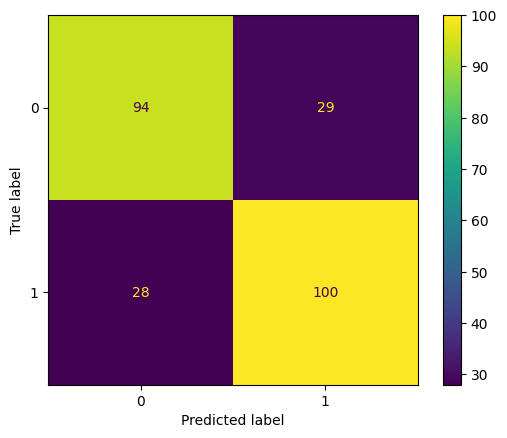

In [49]:
display_report(y_test, predictions)

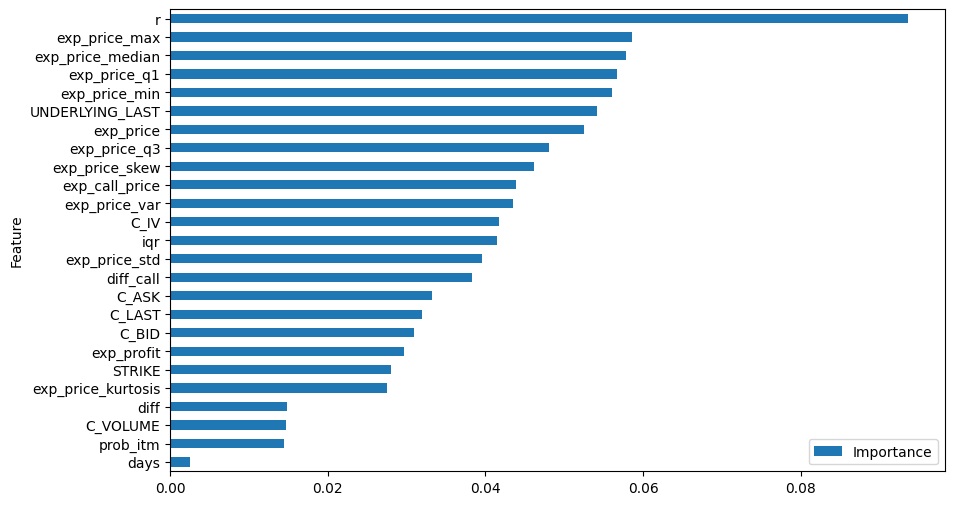

In [50]:
coefficients = best_model.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

### Test model

In [51]:
X_train, X_test, y_train, y_test = train_test_split(new_df.values, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=False)

In [52]:
rf_params = {k[4:]:v for k,v in rf_random.best_params_.items()} | {
 'n_jobs' : 4, 
 'verbose':1}

In [53]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier(**rf_params))])

In [54]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  89 out of  89 | elapsed:    0.4s finished


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=12, min_samples_split=10,
                                        n_estimators=89, n_jobs=4,
                                        random_state=1968, verbose=1))])

In [55]:
predictions = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  89 out of  89 | elapsed:    0.0s finished


In [56]:
pipe.score(X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  89 out of  89 | elapsed:    0.0s finished


0.46613545816733065

In [57]:
insample_preds = pipe.predict(X_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  89 out of  89 | elapsed:    0.0s finished


### Buy only strategy 

### in-sample

In [58]:
strategy = []
date_idx = []
prev_price = 0.0
for i in range(len(insample_preds)):
    row = new_df.iloc[i,:].to_dict()
    quote_date = new_df.index[i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    # Get price at expiration
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if insample_preds[i]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:
        if final_price > strike:
            profit = call_price
        else:
            profit = final_price-strike+call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.0,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [59]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare
Date,,,,,,,,
2018-01-02,1,269.0,1.56,4.795895,2018-01-24,283.179993,12.619993,12.619993
2018-01-03,1,270.0,2.15,4.898009,2018-01-24,283.179993,11.029993,11.029993
2018-01-04,1,272.0,1.67,4.327332,2018-01-24,283.179993,9.509993,9.509993
2018-01-05,1,273.0,2.21,4.899561,2018-01-26,286.579987,11.369987,11.369987
2018-01-08,1,274.0,2.08,4.865014,2018-01-31,281.899994,5.819994,5.819994
...,...,...,...,...,...,...,...,...
2021-12-27,0,477.0,5.76,11.573253,2022-01-18,456.489990,0.000000,-5.760000
2021-12-28,0,477.0,5.29,11.027398,2022-01-18,456.489990,0.000000,-5.290000
2021-12-29,0,478.0,5.43,10.748298,2022-01-19,451.750000,0.000000,-5.430000


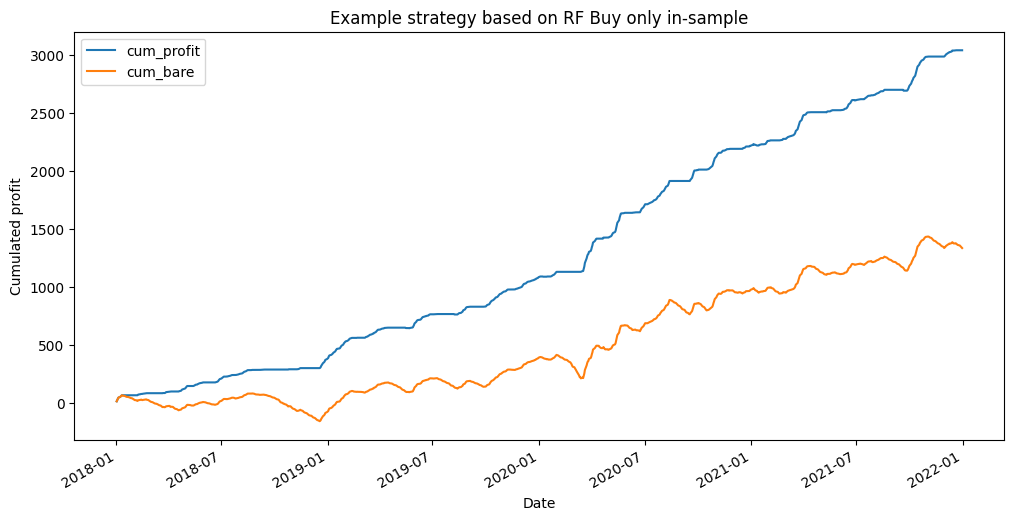

In [60]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on RF Buy only in-sample")
plt.legend()
plt.show()

### out-of-sample

In [61]:
strategy = []
date_idx = []
for x,i in enumerate(range(len(predictions),0,-1)):
    row = new_df.iloc[-i,:].to_dict()
    quote_date = new_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    final_price = spy.loc[exp_date,"Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:    
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [62]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare
Date,,,,,,,,
2022-01-03,0,478.0,4.81,10.248337,2022-01-24,439.839996,0.000000,-4.810000
2022-01-04,0,478.0,4.80,9.610177,2022-01-24,439.839996,0.000000,-4.800000
2022-01-05,1,468.0,8.14,10.191128,2022-01-26,433.380005,-8.140000,-8.140000
2022-01-06,1,468.0,7.00,9.657596,2022-01-26,433.380005,-7.000000,-7.000000
2022-01-07,1,466.0,7.56,9.927762,2022-01-28,441.950012,-7.560000,-7.560000
...,...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,8.453400,2023-01-13,398.500000,0.000000,7.500000
2022-12-26,1,383.0,7.96,8.096501,2023-01-13,398.500000,7.540000,7.540000
2022-12-28,1,377.0,8.75,8.526141,2023-01-20,395.880005,10.130005,10.130005


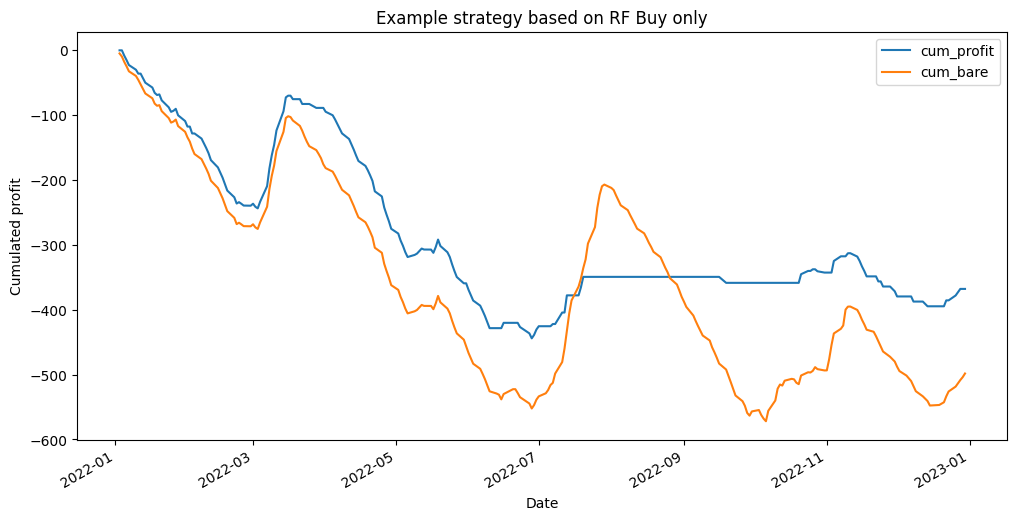

In [63]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on RF Buy only")
plt.legend()
plt.show()